# Eveluation and further visulizatoin
of the redo and optimized models (lr, SVC, RF). This time, the used label is 'facies_merge_2' updated by build_labels.py.

In [1]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# ML Gridsearch

## LR
The gridsearch is executed by grid_lr.py and submit_lr.sh using cluster (no dask involved). The number of searched models is 2 (with or without PCA) * 10 (lr__C) * 5 (cv) = 100. It takes 5 minutes to finish the gridsearch. The best model is without PCA and stored as roll_lr_model_20201120.joblib. The job log is slurm-20905.txt. 

In [22]:
lr_df = pd.read_csv('results/roll_lr_grid_20201120.csv', index_col=0)

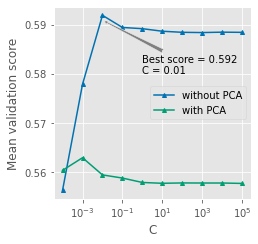

In [34]:
fig = plt.figure(figsize = (3.54, 3.54))

data_df = lr_df.copy()
x_col = 'param_lr__C'
max_index = np.argmax(data_df.mean_test_score)
plt.xscale('log')
#plt.ylim(0.545, 0.595)
plt.yticks(np.linspace(0.56, 0.59, 4))

for label, mask in zip(['without PCA', 'with PCA'], [data_df.param_pca != 'PCA(whiten=True)', data_df.param_pca == 'PCA(whiten=True)']):
    xx = data_df.loc[mask, x_col].values.astype(float)
    yy = data_df.loc[mask, 'mean_test_score'].values.astype(float)
    plt.plot(xx, yy, marker = '^', ms = 4, label = label)

plt.ylabel('Mean validation score')
plt.xlabel('C')
plt.legend()

plt.annotate(text = 'Best score = {:.3f}\nC = {}'.format(data_df.mean_test_score[max_index], data_df.loc[max_index, x_col]),
             xy = (data_df.loc[max_index, x_col], data_df.mean_test_score[max_index]-.001),
             xytext = (1, 0.58), arrowprops=dict(facecolor='gray', arrowstyle = 'fancy')
            )
fig.subplots_adjust(wspace = 0.05)
fig.savefig('results/roll_lr_grid_combined_{}.png'.format(date))

## RBF SVM
The gridsearch is executed by grid_svc.py and submit_svc.sh using cluster (no dask involved). The number of searched models is 2 (with or without PCA) * 9 (svc__gamma) * 7 (svc__C) * 5 (cv) = 630. @@@It takes 11 hours to finish the gridsearch. The best model is without PCA and stored as roll_svc_model_20201121.joblib. The job log is slurm-20834.txt. 

In [3]:
svc_df = pd.read_csv('results/roll_svc_grid_20201120.csv', index_col = 0)
len(svc_df)

126

In [4]:
np.max(svc_df.mean_test_score.astype(float))

0.6296643439351259

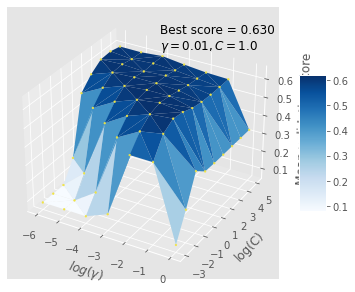

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = plt.gca(projection='3d')
xx = svc_df.loc[svc_df.param_pca != 'PCA(whiten=True)', 'param_svc__gamma'].values.astype(float)
yy = svc_df.loc[svc_df.param_pca != 'PCA(whiten=True)', 'param_svc__C'].values.astype(float)
zz = svc_df.loc[svc_df.param_pca != 'PCA(whiten=True)', 'mean_test_score'].values.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap = cm.Blues, linewidth = 0.1)
ax.scatter(np.log10(xx), np.log10(yy), zz, c = 'C4', s = 3, alpha = 1)

# mark the best score
text = 'Best score = {:.3f}\n$\gamma = {}, C = {}$'.format(zz[max_index], xx[max_index], yy[max_index])
ax.text(-2, 0, .9,text, fontsize = 12)
#ax.quiver(np.log10(xx[max_index]), np.log10(yy[max_index]), zz[max_index], 
#          .3, .3, .3, color='gray', alpha=.6)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('Mean validation score')
fig.colorbar(surf, shrink = 0.5, aspect = 5)
fig.savefig('results/roll_svc_grid_20201121.png')

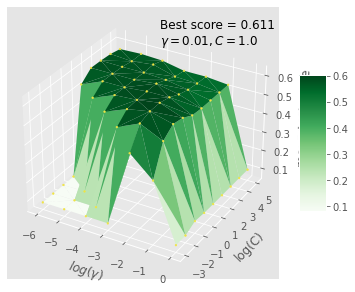

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = plt.gca(projection='3d')
xx = svc_df.loc[svc_df.param_pca == 'PCA(whiten=True)', 'param_svc__gamma'].values.astype(float)
yy = svc_df.loc[svc_df.param_pca == 'PCA(whiten=True)', 'param_svc__C'].values.astype(float)
zz = svc_df.loc[svc_df.param_pca == 'PCA(whiten=True)', 'mean_test_score'].values.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap = cm.Greens, linewidth = 0.1)
ax.scatter(np.log10(xx), np.log10(yy), zz, c = 'C4', s = 3, alpha = 1)
# mark the best score
text = 'Best score = {:.3f}\n$\gamma = {}, C = {}$'.format(zz[max_index], xx[max_index], yy[max_index])
ax.text(-2, 0, .9,text, fontsize = 12)
#ax.quiver(np.log10(xx[max_index]), np.log10(yy[max_index]), zz[max_index], 
#          .3, .3, .3, arrow_length_ratio=0.1, color='gray', alpha=.6)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
fig.colorbar(surf, shrink = 0.5, aspect = 5)
fig.savefig('results/roll_pca+svc_grid_20201121.png')

## RandomForest (RF)
The gridsearch is implemented by grid_rf.py and submit_rf.sh using cluster (no dask involved). Three amounts of n_estimators (100 (default), 1000, 5000) are searched. RF really comsumes a lot memory surign computation. The number of searched models is 2 (with or without PCA) * 3 (rf__n_estimators) * 5 (cv) = 30. It takes 14 minutes to finish the gridsearch. The best model is without PCA and stored as roll_rf_model_20201120.joblib (12.9 GB). The job log is slurm-20835.txt.

Usually, n_estimators is the more the better generalization because it provides more regularization strength. However, the more n_estimators means more computation and memery loading. Although the 5000 n_estimators seems not reach the peak of rising trend and we might find some ways to solve the memory limit of cluster, I don't think it's sensible to persuit the higher n_estimators because the model's size will be too big for later applications.

In [5]:
rf_df = pd.read_csv('results/roll_rf_grid_20201120.csv', index_col = 0)
len(rf_df)

6

In [15]:
13831245542/(2**30)

12.8813512083143

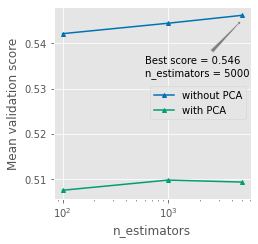

In [33]:
fig = plt.figure(figsize = (3.54, 3.54))

data_df = rf_df.copy()
x_col = 'param_rf__n_estimators'
max_index = np.argmax(data_df.mean_test_score)
plt.xscale('log')
#plt.ylim(0.545, 0.595)
plt.yticks(np.linspace(0.5, 0.54, 5))

for label, mask in zip(['without PCA', 'with PCA'], [data_df.param_pca != 'PCA(whiten=True)', data_df.param_pca == 'PCA(whiten=True)']):
    xx = data_df.loc[mask, x_col].values.astype(float)
    yy = data_df.loc[mask, 'mean_test_score'].values.astype(float)
    plt.plot(xx, yy, marker = '^', ms = 4, label = label)

plt.ylabel('Mean validation score')
plt.xlabel('n_estimators')
plt.legend()

plt.annotate(text = 'Best score = {:.3f}\nn_estimators = {}'.format(data_df.mean_test_score[max_index], data_df.loc[max_index, x_col]),
             xy = (data_df.loc[max_index, x_col], data_df.mean_test_score[max_index]-.001),
             xytext = (600, 0.533), arrowprops=dict(facecolor='gray', arrowstyle = 'fancy')
            )
fig.subplots_adjust(wspace = 0.05)
fig.savefig('results/roll_rf_grid_combined_{}.png'.format(date))

# Evaluation using test set

In [2]:
from split import my_train_test_split

data_df = pd.read_csv('data/XRF_ML_cr.csv')
X = data_df.iloc[:, 1:-2].values
y = data_df['facies_merge_2'].values
groups = data_df['core_section'].values

train_idx, test_idx = my_train_test_split(y, groups)

In [3]:
X[test_idx].shape

(22487, 24)

In [4]:
facies = ['shoreface', 'channel', 'beach-foreshore', 'sand flat', 'mud flat',
       'lagoon', 'peat', 'soil', 'eolian/fluvial (W)',
       'shallow marine', 'moraine', 'eolian/fluvial']

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())

Facies

['Shoreface',
 'Channel',
 'Beach-foreshore',
 'Sand flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Soil',
 'Eolian/fluvial (w)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial']

In [5]:
from joblib import load
lr = load('models/roll_lr_model_20201120.joblib')
svc = load('models/roll_svc_model_20201120.joblib')
rf = load('models/roll_rf_model_20201120.joblib')

In [19]:
y_df = pd.DataFrame(y[test_idx], columns=['y'])
for col, model in zip(['y_lr', 'y_svc', 'y_rf'], [lr, svc, rf]):
    y_df[col] = model.predict(X[test_idx])

In [7]:
y_df

,y,y_lr,y_svc,y_rf
0,1,2,2,1
1,1,2,2,1
2,1,2,2,1
3,1,2,2,1
4,1,2,2,1
...,...,...,...,...
22482,6,6,6,6
22483,6,6,6,6
22484,6,6,6,6
22485,6,6,6,6


# Evaluation

## Balanced score

In [8]:
from sklearn.metrics import balanced_accuracy_score as score
for col in ['y_lr', 'y_svc', 'y_rf']:
    print('Balanced score of {}: {:.2f}'.format(col, score(y_true=y_df.y, y_pred=y_df[col])))

Balanced score of y_lr: 0.57
Balanced score of y_svc: 0.61
Balanced score of y_rf: 0.48


## Recall matrix
It is modified from confusion matrix, disigned to evaluate the accuracy of a classification. The confusion matrix is first computed. Then the numbers (counts) are normalized by the sum of each row (i.e., sum of true positive and false negative). The ratios in diagonal represent recall in percent. This give us the view of "how many data points in percent described as facies A by sedimentologists are recognized correctly as A and falsely as other facies by models. The accuracy in xlabel is the balanced score.

In [22]:
def plot_recall(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test)
    """
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import balanced_accuracy_score as score

    for col in y_preds:
        # make confusion matrix between prediction and actual labels
        confusion = confusion_matrix(data_df.y, data_df[col])
        model_name = col[2:]
        con_df = pd.DataFrame(confusion, index = Facies, columns = Facies)
        #con_df.to_csv('results/roll_confusion_{}_{}.csv'.format(model_name, date))

        # normalize the counts ineach row and present in percent
        x = np.copy(confusion).astype(float)
        x /= x.sum(axis = 1, keepdims = True)
        con_per = pd.DataFrame((x*100).astype(int), index = Facies, columns = Facies)
        #con_per.to_csv('results/roll_recall_%_{}_{}.csv'.format(model_name, date))

        # Plot the matrix
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(con_per, annot = con_per.astype(str), ax = ax, cmap = 'GnBu', square = True, vmin=0, vmax=100,
                    xticklabels = con_per.index, yticklabels = con_per.columns, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Data percentage in each row'}
                   )

        ax.set_xlabel('Prediction (accuracy: {:.2f})'.format(score(y_true=data_df.y, y_pred=data_df[col])), size = 14)
        ax.set_ylabel('Actual facies', size = 14)
        fig.savefig('results/roll_{}_recall_%_{}_{}.png'.format(split, model_name, date))

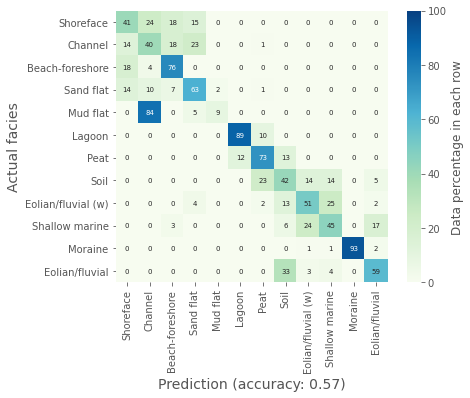

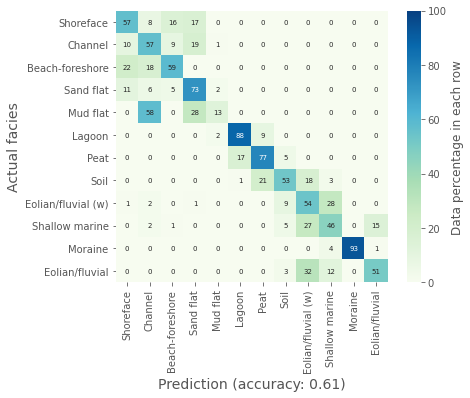

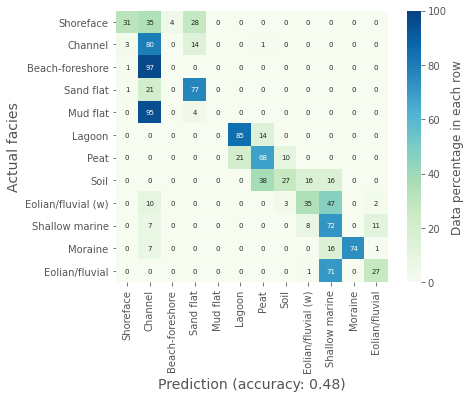

In [28]:
plot_recall(y_df, ['y_lr', 'y_svc', 'y_rf'], Facies, 'test' )

## Check mud flat
It should be solved...why?

In [20]:
y_df['composite_id'] = data_df.composite_id.values[test_idx]
y_df.set_index('composite_id', inplace=True)
y_df = pd.concat([pd.read_csv('data/info.cleaned.all.csv', index_col=0, usecols=['composite_id', 'composite_depth_mm', 'section_depth_mm', 'core_id', 'core_section']), y_df], 
                   axis=1, join='inner') 

In [82]:
y_df

,composite_depth_mm,core_id,core_section,section_depth_mm,y,y_lr,y_svc,y_rf
composite_id,,,,,,,,
N12_00052,52,N12,N12-4,102.0,1,0,0,1
N12_00054,54,N12,N12-4,104.0,1,0,0,1
N12_00056,56,N12,N12-4,106.0,1,0,0,1
N12_00058,58,N12,N12-4,108.0,1,0,0,1
N12_00060,60,N12,N12-4,110.0,1,0,0,1
...,...,...,...,...,...,...,...,...
W5_02133,2133,W5,W5-1,2133.0,6,6,6,6
W5_02135,2135,W5,W5-1,2135.0,6,6,6,6
W5_02137,2137,W5,W5-1,2137.0,6,6,6,6


In [15]:
y_df[y_df.y==4]

,composite_depth_mm,core_id,core_section,section_depth_mm,y,y_lr,y_svc,y_rf,id
composite_id,,,,,,,,,
N52_00042,42,N52,N52-3,42.0,4,1,1,1,8262
N52_00044,44,N52,N52-3,44.0,4,1,1,1,8263
N52_00046,46,N52,N52-3,46.0,4,1,1,1,8264
N52_00048,48,N52,N52-3,48.0,4,1,1,1,8265
N52_00050,50,N52,N52-3,50.0,4,1,1,1,8266
...,...,...,...,...,...,...,...,...,...
N52_00336,336,N52,N52-3,336.0,4,3,3,3,8380
N52_00338,338,N52,N52-3,338.0,4,3,3,3,8381
N52_00340,340,N52,N52-3,340.0,4,3,3,3,8382


In [16]:
def plot_facies(data_df, core, y_preds, Facies):
    """
    data_df is the dataframe having info and labels.
    core is the string of the core you want to plot.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    """
    X = data_df[data_df.core_id == core]
    plt.figure(figsize = (3.54, 7.25))
    plt.scatter(X.y - .2, X.composite_depth_mm, marker = 's', s = 1, lw = .5, label = 'description')
    for i, y_pred in enumerate(y_preds):
        plt.scatter(X[y_pred] + .15*i, X.composite_depth_mm, marker = 's', s = 1, lw = .5, label = y_pred)
    plt.ylim(X.composite_depth_mm.max() + 20, 0)
    plt.ylabel('Composite depth (mm)')
    plt.xticks(np.unique(data_df.y), Facies, rotation = 90)
    plt.legend(markerscale=3, title=core)

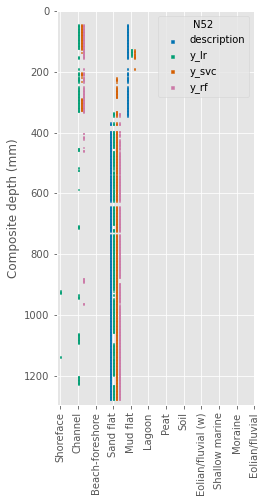

In [17]:
plot_facies(y_df, 'N52', ['y_lr', 'y_svc', 'y_rf'], Facies)

## Conjunction matrix
It displays how the facies changes along the core. 

In [24]:
def detect_conjuction(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test).
    """
    
    data_df['id'] = range(len(data_df))
    mat_dict = {}


    for y_pred in y_preds:
        y_mean = []
        composite_id = []
        model_name = y_pred[2:] if len(y_pred)>1 else 'description'
        
        for section in np.unique(data_df.core_section):
            y_mean = np.hstack((y_mean, data_df.loc[data_df.core_section == section, y_pred].rolling(window = 2).mean()))
            composite_id = np.hstack((composite_id, data_df[data_df.core_section == section].index))

        # merge the rolling with the original label
        # this will lost the first data poit in each section, but it doesn't mater
        # because the boundary shouldn't be at the begining of each section
        tmp_df = pd.concat([data_df, pd.DataFrame({'y_mean': y_mean}, index = composite_id).dropna()], join = 'inner', axis = 1)

        # if y_pred is not same as y_mean, it means there is a boundary (facies change) between this and above depth
        bd_df = tmp_df[tmp_df[y_pred] != tmp_df.y_mean].copy()
        bd_df['ab_id'] = bd_df.id - 1
        if len(model_name) > 3:
            print('There are {} boundaries in description.'.format(len(bd_df)))
        else:
            print('There are {} boundaries in the optimized {} model\'s predictions.'.format(len(bd_df), model_name))

        # build matrix of boundaries
        bd_mat = np.zeros(shape = (12, 12), dtype = int)

        for row in bd_df.iterrows():
            tmp = np.zeros(shape = (12, 12), dtype = int)
            tmp[data_df[y_pred][int(row[1].ab_id)], data_df[y_pred][int(row[1].id)]] = 1
            bd_mat += tmp
            
        mat_dict[y_pred] = bd_mat
        
        # plot
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(bd_mat, annot = bd_mat.astype(str), ax = ax, cmap = 'Greens', square = True, #vmin=0, vmax=130,
                    xticklabels = Facies, yticklabels = Facies, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Counts (total: {})'.format(len(bd_df))}
                   )
        ax.set_xlabel('Below facies', size = 16)
        ax.set_ylabel('Above facies', size = 16)
        fig.savefig('results/roll_{}_conjunction_matrix_{}_{}.png'.format(split, model_name, date))
    
    return mat_dict

There are 29 boundaries in description.
There are 1371 boundaries in the optimized lr model's predictions.
There are 1273 boundaries in the optimized svc model's predictions.
There are 729 boundaries in the optimized rf model's predictions.


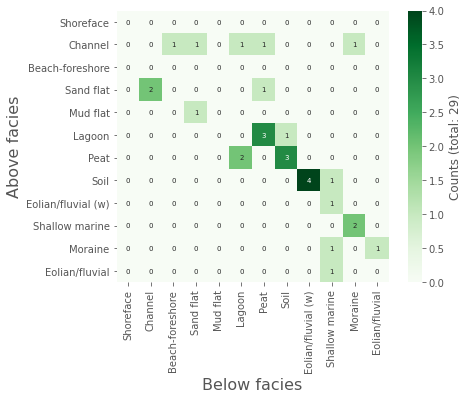

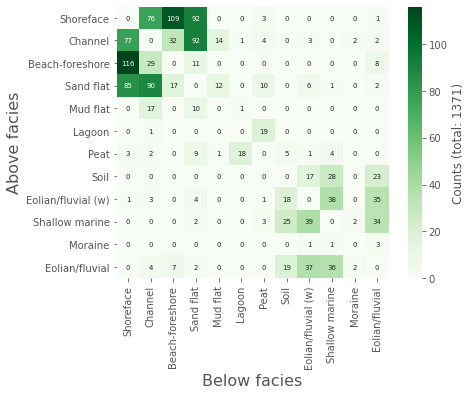

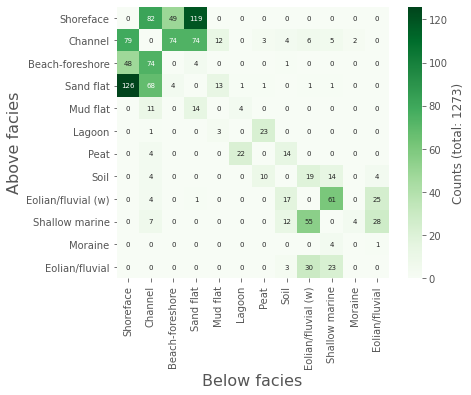

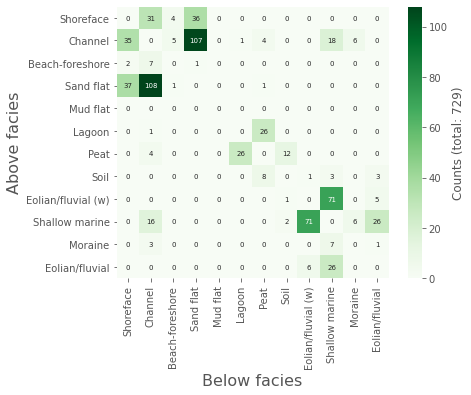

In [26]:
mat_dict = detect_conjuction(y_df,  ['y', 'y_lr', 'y_svc', 'y_rf'], Facies, 'test')

The accuracy inot proved much...Let's see how the confusion matix in training set.

# Training set

In [6]:
len(y[train_idx])

130870

In [7]:
y_train_df = pd.DataFrame(y[train_idx], columns=['y'])
for col, model in zip(['y_lr', 'y_svc', 'y_rf'], [lr, svc, rf]):
    y_train_df[col] = model.predict(X[train_idx])

In [10]:
y_train_df

,y,y_lr,y_svc,y_rf
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
130865,3,3,3,3
130866,3,3,3,3
130867,3,3,3,3
130868,3,3,3,3


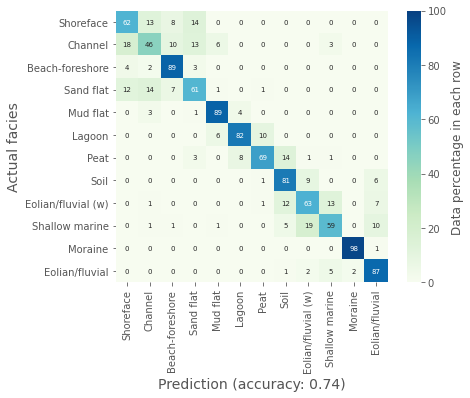

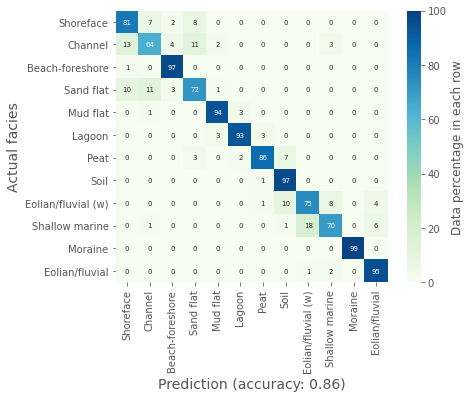

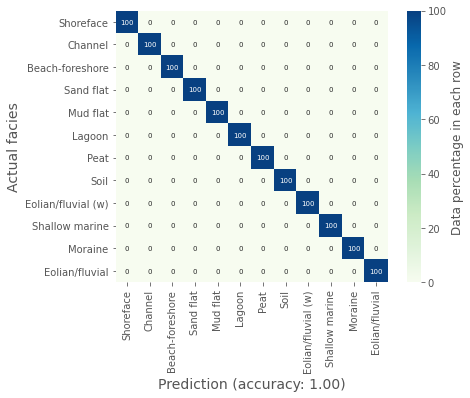

In [30]:
plot_recall(y_train_df,  ['y_lr', 'y_svc', 'y_rf'], Facies, 'train')

In [13]:
y_train_df['composite_id'] = data_df.composite_id.values[train_idx]
y_train_df.set_index('composite_id', inplace=True)
y_train_df = pd.concat([pd.read_csv('data/info.cleaned.all.csv', index_col=0, usecols=['composite_id', 'composite_depth_mm', 'section_depth_mm', 'core_id', 'core_section']), y_train_df], 
                   axis=1, join='inner') 

## Conjunction matrix
It displays how the facies changes along the core. 

There are 117 boundaries in description.
There are 7545 boundaries in the optimized lr model's predictions.
There are 5318 boundaries in the optimized svc model's predictions.
There are 117 boundaries in the optimized rf model's predictions.


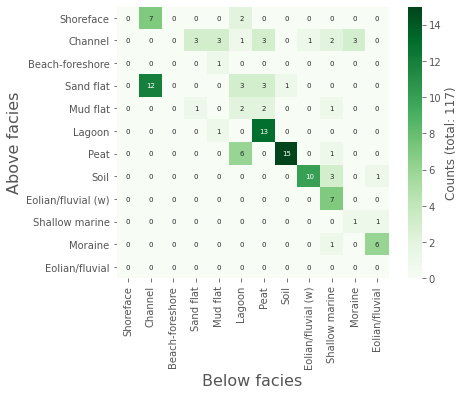

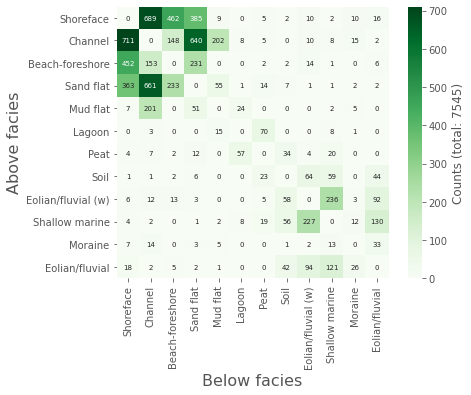

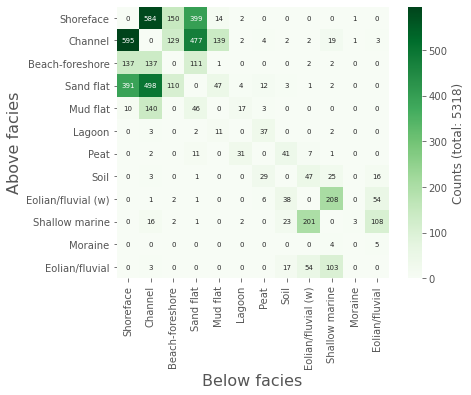

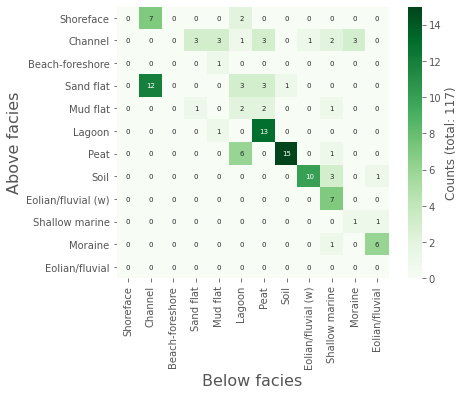

In [27]:
mat_dict = detect_conjuction(y_train_df,  ['y', 'y_lr', 'y_svc', 'y_rf'], Facies, 'train')

In [29]:
from sklearn.metrics import balanced_accuracy_score as score
for col in ['y_lr', 'y_svc', 'y_rf']:
    print('Balanced scores of {} in training set: {:.2f}, in test set: {:.2f}'.format(col[2:], score(y_true=y_train_df.y, y_pred=y_train_df[col]), score(y_true=y_df.y, y_pred=y_df[col])))

Balanced scores of lr in training set: 0.74, in test set: 0.57
Balanced scores of svc in training set: 0.86, in test set: 0.61
Balanced scores of rf in training set: 1.00, in test set: 0.48


Clearly they all have overfitting problem...However, from the tomography of lr's and svc's gridsearch reaults, I don't think there is likely stricter regularization can be applied to have better validatoin score. The plateau towards to the less regulerization settings, while the down-slope towards to the stricter regulerization settings. Only RF might have the space for prunching leaves (i.e., reduce max_depth). I will try to optimize RF seems it also have less fragmented characteristic.